**1.Importing Necessary Libraries**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [2]:
#Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**2.Loading Dataset and applying transformations**

In [3]:
#Defining transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Loading CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



# Creating DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Class names in CIFAR-10
classes = train_dataset.classes

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**3. Exploratory Data Analysis**

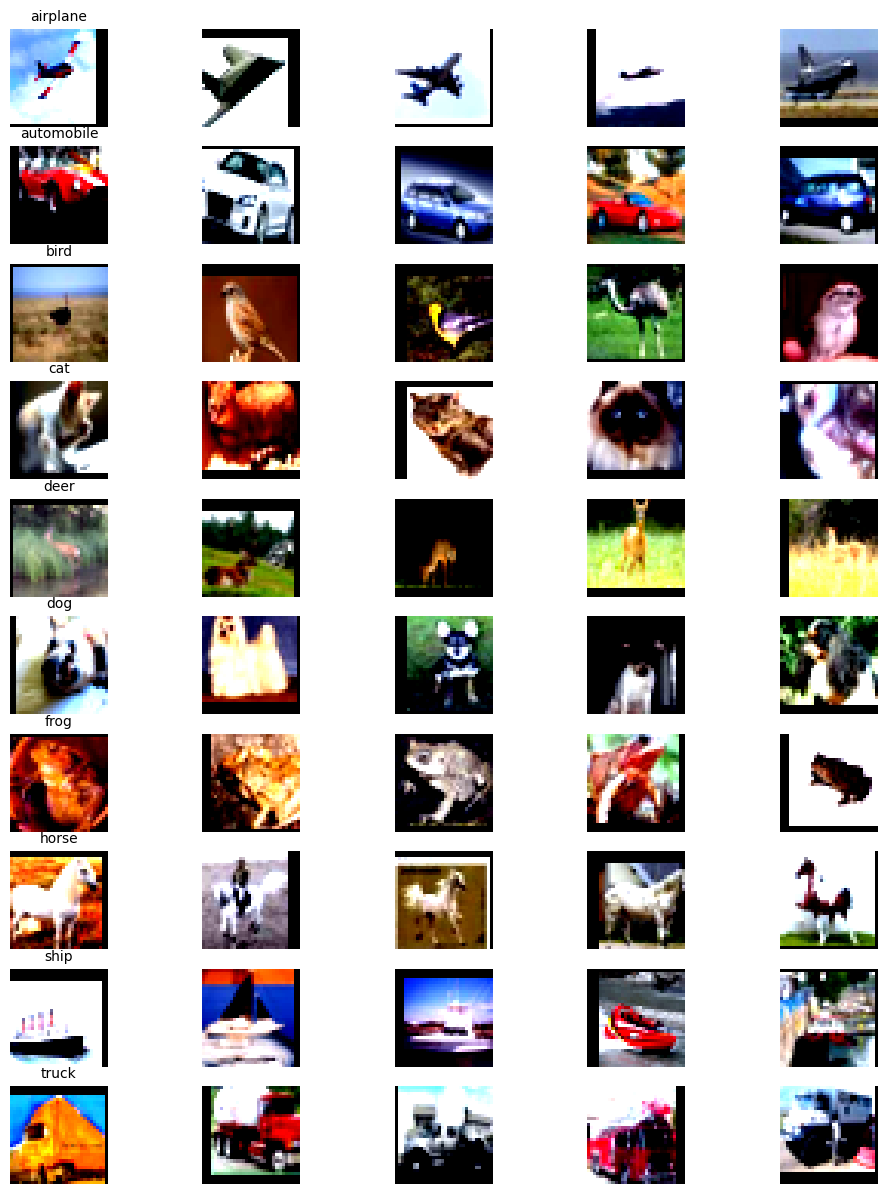

In [4]:
#Visualising images
def show_images_by_class(data_loader, classes, num_images=5):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(12, 15))
    images_per_class = {class_name: [] for class_name in classes}

    for images, labels in data_loader:
        for i in range(len(images)):
            class_name = classes[labels[i]]
            if len(images_per_class[class_name]) < num_images:
                images_per_class[class_name].append(images[i])
        if all(len(images_per_class[class_name]) == num_images for class_name in classes):
            break

    for class_idx, class_name in enumerate(classes):
        for img_idx, img in enumerate(images_per_class[class_name]):
            img = img / 2 + 0.5  # Unnormalize
            img = img.numpy().transpose((1, 2, 0))
            axes[class_idx, img_idx].imshow(img)
            axes[class_idx, img_idx].axis('off')
            if img_idx == 0:
                axes[class_idx, img_idx].set_title(class_name, fontsize=10)
    plt.show()

show_images_by_class(train_loader, classes)


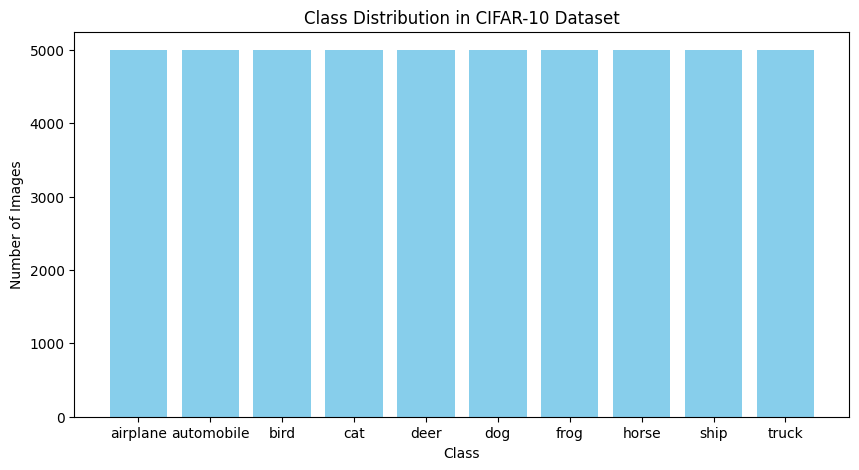

In [5]:
#Checking class distribution
from collections import Counter

class_counts = Counter(train_dataset.targets)
class_labels = list(classes)
class_values = [class_counts[i] for i in range(len(classes))]

plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_values, color='skyblue')
plt.title("Class Distribution in CIFAR-10 Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [6]:
#Calculating mean and standard deviation  of images
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        batch_images_count = images.size(0)
        images = images.view(batch_images_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_images_count

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = calculate_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([-0.3305, -0.3382, -0.3121])
Standard Deviation: tensor([1.2546, 1.2487, 1.2038])


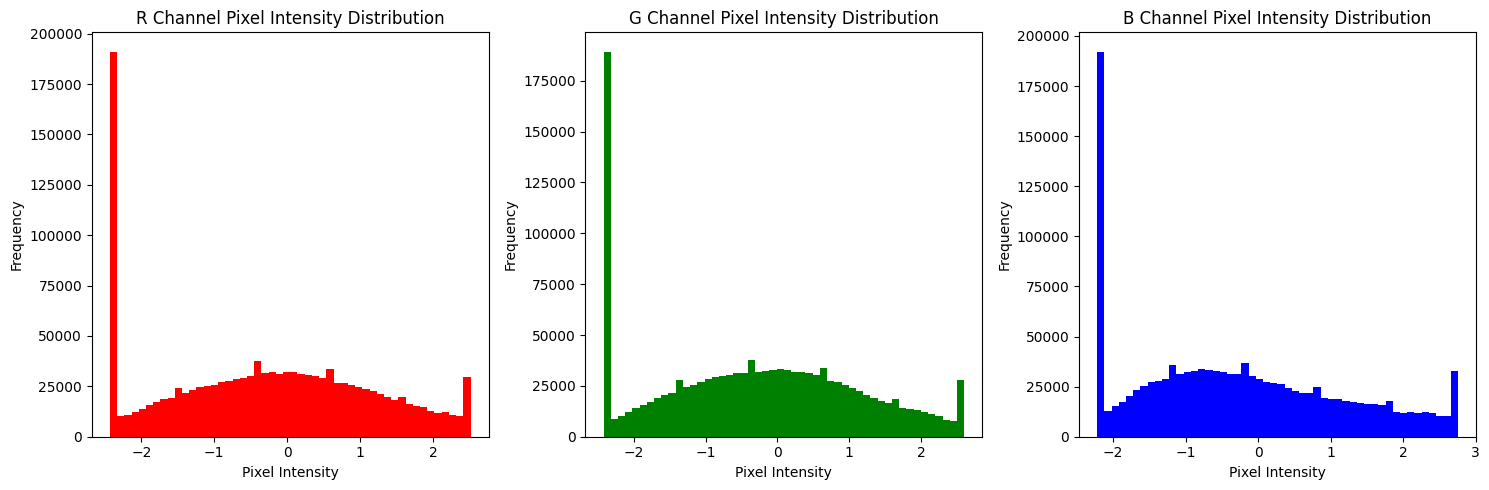

In [7]:
#Visualising pixel intensity
def plot_pixel_intensity_distribution(loader, num_batches=10):
    pixels = { 'R': [], 'G': [], 'B': [] }
    channels = ['R', 'G', 'B']

    for i, (images, _) in enumerate(loader):
        if i >= num_batches:
            break
        for j, color in enumerate(channels):
            pixels[color].extend(images[:, j, :, :].numpy().flatten())

    plt.figure(figsize=(15, 5))
    for idx, color in enumerate(channels):
        plt.subplot(1, 3, idx + 1)
        plt.hist(pixels[color], bins=50, color=color.lower())
        plt.title(f"{color} Channel Pixel Intensity Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_pixel_intensity_distribution(train_loader)

Files already downloaded and verified
Augmented Images:


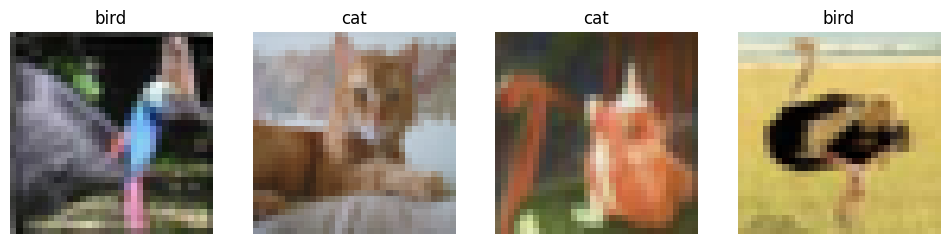

In [8]:
#Verifying Data Augmentation

# Define transformation without padding and RandomRotation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),  # No padding to prevent border artifacts
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


# Load CIFAR-10 dataset with the updated transformation
train_dataset_augmented = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=4, shuffle=True)

# Class names for CIFAR-10
classes = train_dataset_augmented.classes

# Function to visualize augmented images with unnormalization
def show_augmented_images(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Unnormalize images for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    images = images * std + mean  # Unnormalize for display

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for idx in range(4):
        img = images[idx].numpy().transpose((1, 2, 0))  # Convert to HWC format
        img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
        axes[idx].imshow(img)
        axes[idx].set_title(classes[labels[idx]])
        axes[idx].axis('off')
    plt.show()

print("Augmented Images:")
show_augmented_images(train_loader_augmented)


**VGG-16- Baseline model**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Training Accuracy: 0.5440, Validation Accuracy: 0.6741
Epoch 2/15, Training Accuracy: 0.7295, Validation Accuracy: 0.7619
Epoch 3/15, Training Accuracy: 0.7723, Validation Accuracy: 0.7706
Epoch 4/15, Training Accuracy: 0.7989, Validation Accuracy: 0.7985
Epoch 5/15, Training Accuracy: 0.8219, Validation Accuracy: 0.8175
Epoch 6/15, Training Accuracy: 0.8443, Validation Accuracy: 0.8297
Epoch 7/15, Training Accuracy: 0.8546, Validation Accuracy: 0.8324
Epoch 8/15, Training Accuracy: 0.8622, Validation Accuracy: 0.8335
Epoch 9/15, Training Accuracy: 0.8706, Validation Accuracy: 0.8397
Epoch 10/15, Training Accuracy: 0.8744, Validation Accuracy: 0.8413
Epoch 11/15, Training Accuracy: 0.8916, Validation Accuracy: 0.8504
Epoch 12/15, Training Accuracy: 0.8950, Validation Accuracy: 0.8547
Epoch 13/15, Training Accuracy: 0.8993, Validation Accuracy: 0.8495
Epoch 14/15, Training Accuracy: 0.9013, Validatio

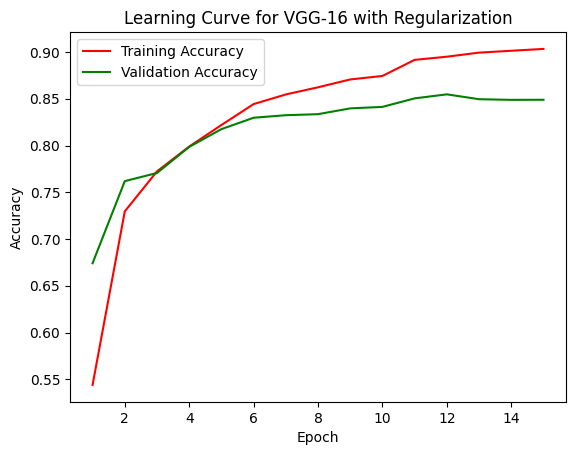

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.95      0.90      0.93      1000
           2       0.83      0.83      0.83      1000
           3       0.77      0.68      0.72      1000
           4       0.82      0.84      0.83      1000
           5       0.72      0.82      0.77      1000
           6       0.91      0.88      0.89      1000
           7       0.89      0.85      0.87      1000
           8       0.93      0.92      0.93      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



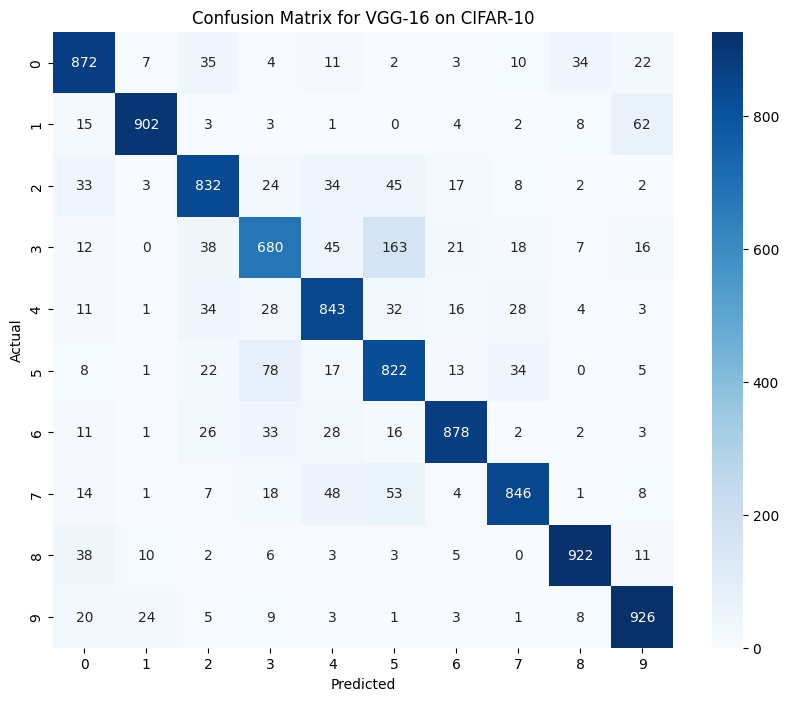

In [ ]:
# Loading the modified VGG-16 model with additional dropout
class VGG16_CIFAR10(nn.Module):
    def __init__(self):
        super(VGG16_CIFAR10, self).__init__()
        # Loading the VGG-16 model pre-trained on ImageNet
        self.model = models.vgg16(pretrained=True)
        # Modifying the final classifier layer to output 10 classes for CIFAR-10
        self.model.classifier[6] = nn.Linear(4096, 10)
        # Add dropout to the fully connected layers
        self.model.classifier[3] = nn.Dropout(0.5)
        self.model.classifier[5] = nn.Dropout(0.5)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16_CIFAR10().to(device)

# Data transformations with increased data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset and split it into training and validation sets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Loss function and optimizer with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with validation and learning rate scheduling
train_accuracies = []
val_accuracies = []
epochs = 15
early_stopping_patience = 3  # Stop if no improvement in validation for 'n' epochs
best_val_accuracy = 0
no_improvement_epochs = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        if outputs.size(0) != targets.size(0):
            continue

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if outputs.size(0) != targets.size(0):
                continue

            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for VGG-16')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for VGG-16 on CIFAR-10')
plt.show()


**VGG-16- Hyperparametric optimisation**

In [9]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-06 08:05:02,629] A new study created in memory with name: no-name-9e2f0feb-31bd-43f8-80d7-a5948dc698a0
[I 2024-11-06 08:08:44,662] Trial 0 finished with value: 0.861 and parameters: {'dropout': 0.33337000707810527, 'lr': 0.00022920450758813255, 'weight_decay': 7.145790730973122e-05}. Best is trial 0 with value: 0.861.
[I 2024-11-06 08:12:25,672] Trial 1 finished with value: 0.793 and parameters: {'dropout': 0.46961689923366245, 'lr': 0.0008843937943277141, 'weight_decay': 2.056973877289676e-06}. Best is trial 0 with value: 0.861.
[I 2024-11-06 08:16:07,358] Trial 2 finished with value: 0.7744 and parameters: {'dropout': 0.48693035141206387, 'lr': 0.0009753217558342677, 'weight_decay': 0.0004226242729698093}. Best is trial 0 with value: 0.861.
[I 2024-11-06 08:19:48,028] Trial 3 finished with value: 0.8534 and parameters: {'dropout': 0.4008110690630249, 'lr': 0.0002745811296137369, 'weight_decay': 8.701543657626848e-06}. Best is trial 0 with value: 0.861.
[I 2024-11-06 08:23:

Best hyperparameters found:
{'dropout': 0.33337000707810527, 'lr': 0.00022920450758813255, 'weight_decay': 7.145790730973122e-05}
Best validation accuracy: 0.861
Epoch 1/15, Training Accuracy: 0.5545, Validation Accuracy: 0.6876
Epoch 2/15, Training Accuracy: 0.7386, Validation Accuracy: 0.7765
Epoch 3/15, Training Accuracy: 0.7839, Validation Accuracy: 0.7834
Epoch 4/15, Training Accuracy: 0.8048, Validation Accuracy: 0.8049
Epoch 5/15, Training Accuracy: 0.8231, Validation Accuracy: 0.8232
Epoch 6/15, Training Accuracy: 0.8548, Validation Accuracy: 0.8362
Epoch 7/15, Training Accuracy: 0.8679, Validation Accuracy: 0.8493
Epoch 8/15, Training Accuracy: 0.8751, Validation Accuracy: 0.8505
Epoch 9/15, Training Accuracy: 0.8807, Validation Accuracy: 0.8576
Epoch 10/15, Training Accuracy: 0.8883, Validation Accuracy: 0.8550
Epoch 11/15, Training Accuracy: 0.9059, Validation Accuracy: 0.8671
Epoch 12/15, Training Accuracy: 0.9093, Validation Accuracy: 0.8712
Epoch 13/15, Training Accuracy:

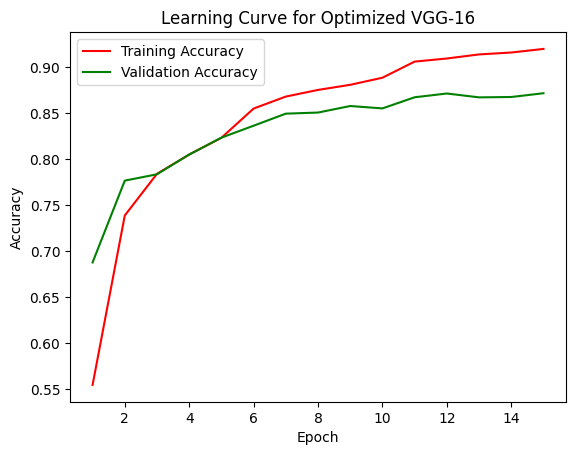

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1000
           1       0.94      0.92      0.93      1000
           2       0.84      0.82      0.83      1000
           3       0.71      0.76      0.74      1000
           4       0.85      0.85      0.85      1000
           5       0.75      0.83      0.79      1000
           6       0.94      0.86      0.90      1000
           7       0.90      0.87      0.89      1000
           8       0.92      0.93      0.92      1000
           9       0.89      0.92      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



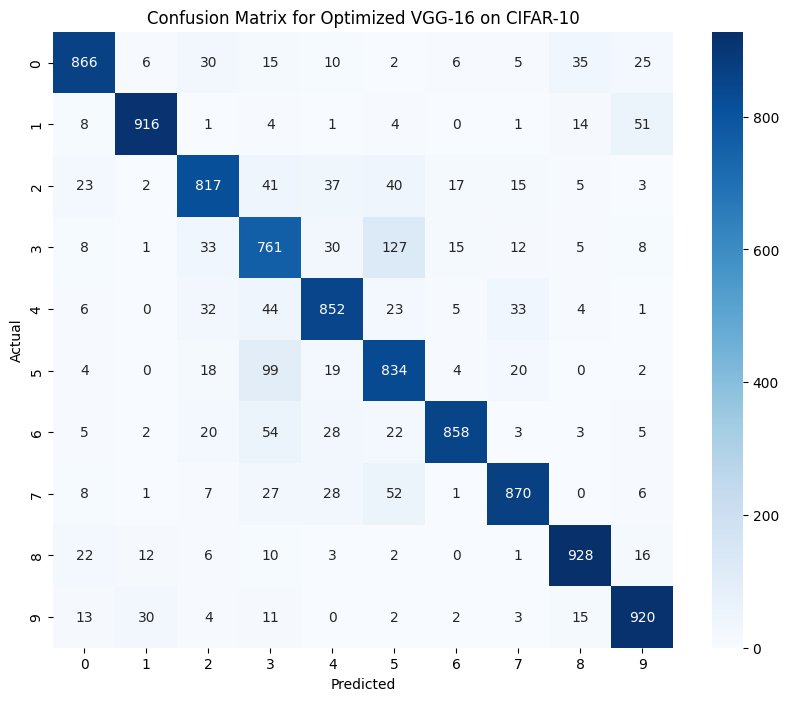

In [ ]:
import optuna
# Define the modified VGG-16 model with configurable dropout
class VGG16_CIFAR10(nn.Module):
    def __init__(self, dropout):
        super(VGG16_CIFAR10, self).__init__()
        # Load the VGG-16 model pre-trained on ImageNet with updated weights argument
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # Modify the final classifier layer to output 10 classes for CIFAR-10
        self.model.classifier[6] = nn.Linear(4096, 10)
        # Add dropout to the fully connected layers
        self.model.classifier[3] = nn.Dropout(dropout)
        self.model.classifier[5] = nn.Dropout(dropout)

    def forward(self, x):
        return self.model(x)


# Download and prepare CIFAR-10 dataset outside the Optuna objective function
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Define the hyperparameter tuning function
def objective(trial):
    # Hyperparameters to be tuned
    dropout = trial.suggest_float("dropout", 0.3, 0.6)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Initialize model, criterion, and optimizer
    model = VGG16_CIFAR10(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Create data loaders using the preloaded datasets
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

    # Training loop
    epochs = 10  # For tuning purposes
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Validation phase
    model.eval()
    val_targets = []
    val_preds = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_targets.extend(targets.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_targets, val_preds)
    return val_accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run Optuna study for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Number of trials for tuning

# Print best hyperparameters
print("Best hyperparameters found:")
print(study.best_params)
print("Best validation accuracy:", study.best_value)

# Retrain model with the best hyperparameters
best_params = study.best_params
model = VGG16_CIFAR10(dropout=best_params['dropout']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Full training with optimal hyperparameters
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

train_accuracies = []
val_accuracies = []
epochs = 15
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step()

# Plot learning curves
plt.plot(range(1, epochs + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for Optimized VGG-16')
plt.show()

# Test set evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized VGG-16 on CIFAR-10')
plt.show()


**ResNet-18--Baseline model**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Training Accuracy: 0.3960, Validation Accuracy: 0.5846
Epoch 2/15, Training Accuracy: 0.6000, Validation Accuracy: 0.6597
Epoch 3/15, Training Accuracy: 0.6577, Validation Accuracy: 0.6863
Epoch 4/15, Training Accuracy: 0.6909, Validation Accuracy: 0.7089
Epoch 5/15, Training Accuracy: 0.7119, Validation Accuracy: 0.7217
Epoch 6/15, Training Accuracy: 0.7337, Validation Accuracy: 0.7398
Epoch 7/15, Training Accuracy: 0.7449, Validation Accuracy: 0.7566
Epoch 8/15, Training Accuracy: 0.7456, Validation Accuracy: 0.7498
Epoch 9/15, Training Accuracy: 0.7574, Validation Accuracy: 0.7487
Epoch 10/15, Training Accuracy: 0.7615, Validation Accuracy: 0.7544
Early stopping due to no improvement in validation accuracy.


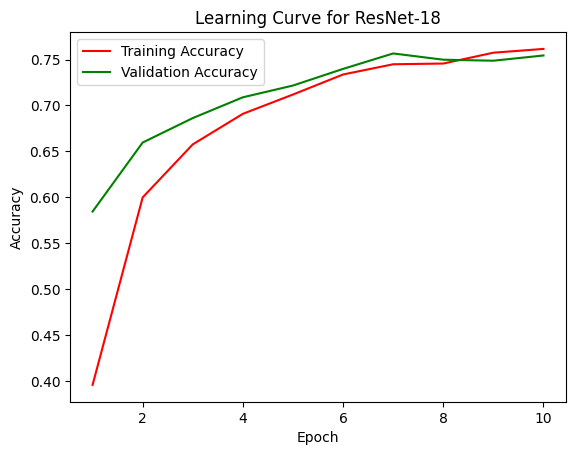

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1000
           1       0.85      0.85      0.85      1000
           2       0.69      0.67      0.68      1000
           3       0.61      0.57      0.59      1000
           4       0.72      0.72      0.72      1000
           5       0.69      0.68      0.68      1000
           6       0.80      0.81      0.80      1000
           7       0.79      0.81      0.80      1000
           8       0.83      0.86      0.84      1000
           9       0.83      0.80      0.81      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



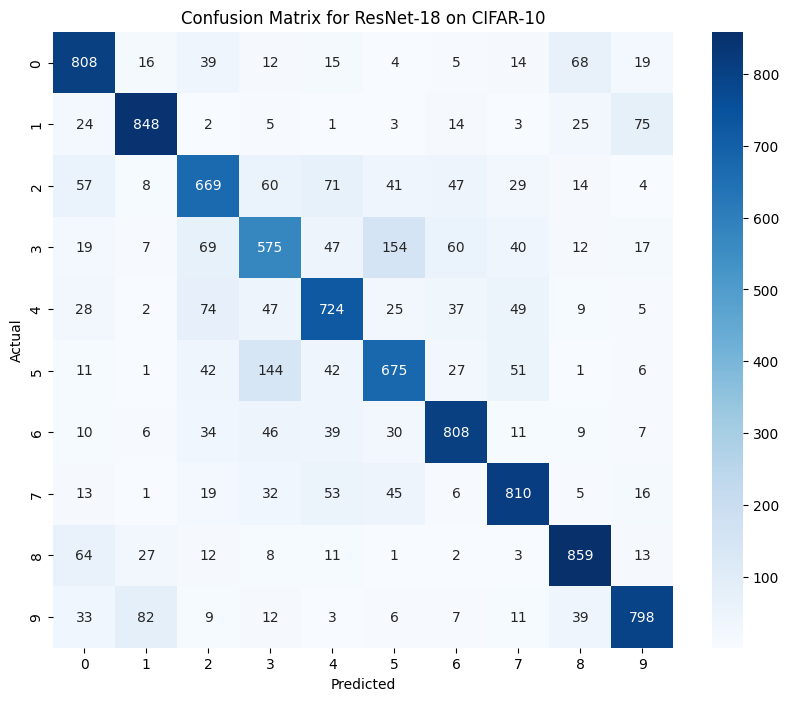

In [ ]:
# Load the modified ResNet-18 model with dropout in the final layers
class ResNet18_CIFAR10(nn.Module):
    def __init__(self):
        super(ResNet18_CIFAR10, self).__init__()
        # Load the ResNet-18 model pre-trained on ImageNet
        self.model = models.resnet18(pretrained=True)
        # Modify the final fully connected layer to output 10 classes for CIFAR-10
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Adding dropout before the final layer
            nn.Linear(num_ftrs, 10)
        )

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18_CIFAR10().to(device)

# Training loop with early stopping
train_accuracies = []
val_accuracies = []
epochs = 15
early_stopping_patience = 3  # Stop if no improvement in validation accuracy for 'n' epochs
best_val_accuracy = 0
no_improvement_epochs = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for ResNet-18')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ResNet-18 on CIFAR-10')
plt.show()


**ResNet-18--Hyperparametric optimisation**

Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-06 10:29:56,634] A new study created in memory with name: no-name-1114b176-ddca-4f48-a820-4028a007cde4
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2024-11-06 10:34:22,520] Trial 0 finished with value: 0.6277 and parameters: {'dropout_rate': 0.6241890250321438, 'learning_rate': 1.640914374872651e-05, 'weight_decay': 2.0824502492665095e-05}. Best is trial 0 with value: 0.6277.
[I 2024-11-06 10:38:47,907] T

Best hyperparameters:  {'dropout_rate': 0.6166536528308428, 'learning_rate': 0.0004677538892259788, 'weight_decay': 1.8306657179446032e-06}
Epoch 1/15, Training Accuracy: 0.5007, Validation Accuracy: 0.6215
Epoch 2/15, Training Accuracy: 0.6609, Validation Accuracy: 0.6974
Epoch 3/15, Training Accuracy: 0.6962, Validation Accuracy: 0.6716
Epoch 4/15, Training Accuracy: 0.7242, Validation Accuracy: 0.7136
Epoch 5/15, Training Accuracy: 0.7341, Validation Accuracy: 0.7373
Epoch 6/15, Training Accuracy: 0.7686, Validation Accuracy: 0.7567
Epoch 7/15, Training Accuracy: 0.7798, Validation Accuracy: 0.7617
Epoch 8/15, Training Accuracy: 0.7837, Validation Accuracy: 0.7713
Epoch 9/15, Training Accuracy: 0.7912, Validation Accuracy: 0.7718
Epoch 10/15, Training Accuracy: 0.7976, Validation Accuracy: 0.7794
Epoch 11/15, Training Accuracy: 0.8120, Validation Accuracy: 0.7901
Epoch 12/15, Training Accuracy: 0.8208, Validation Accuracy: 0.7955
Epoch 13/15, Training Accuracy: 0.8251, Validation Ac

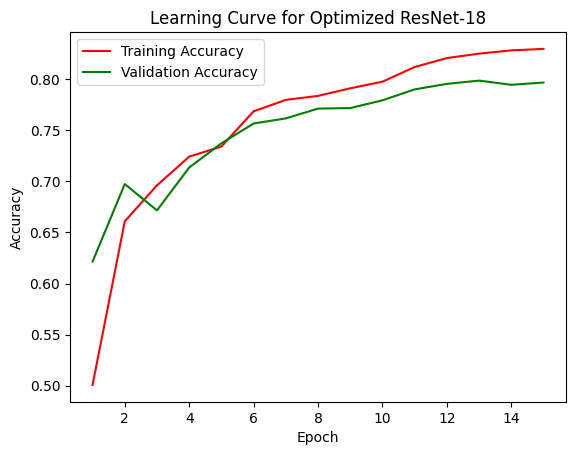

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1000
           1       0.87      0.89      0.88      1000
           2       0.76      0.74      0.75      1000
           3       0.62      0.67      0.65      1000
           4       0.78      0.78      0.78      1000
           5       0.77      0.68      0.72      1000
           6       0.84      0.84      0.84      1000
           7       0.83      0.85      0.84      1000
           8       0.89      0.84      0.87      1000
           9       0.83      0.84      0.83      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



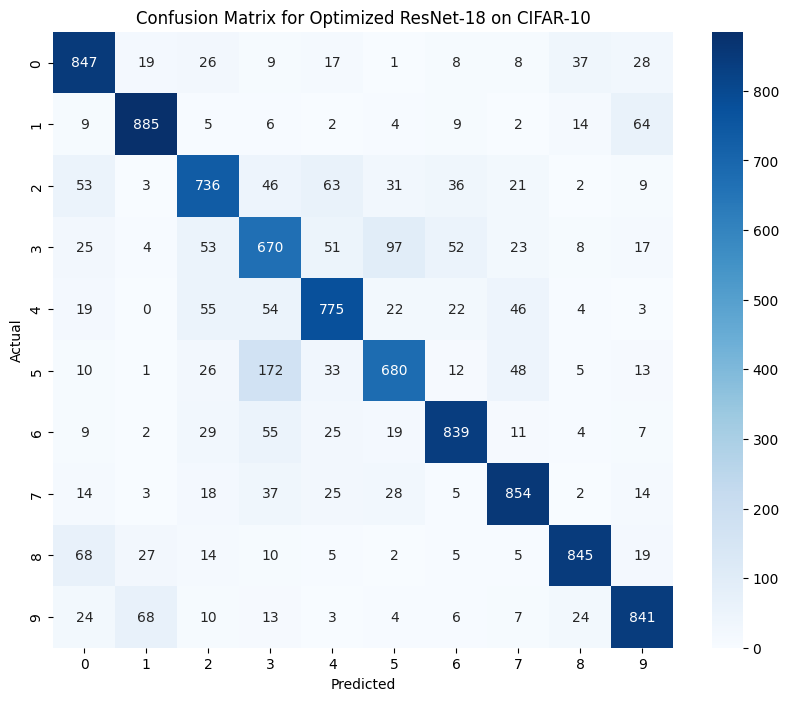

In [ ]:
# Define the model with customizable dropout
class ResNet18_CIFAR10(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet18_CIFAR10, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 10)
        )

    def forward(self, x):
        return self.model(x)

# Objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.7)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Model, criterion, optimizer, and scheduler
    model = ResNet18_CIFAR10(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training loop
    best_val_accuracy = 0
    early_stopping_patience = 3
    no_improvement_epochs = 0
    epochs = 10  # Use fewer epochs for tuning

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        val_accuracy = correct_val / total_val
        scheduler.step()

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= early_stopping_patience:
                break

    return best_val_accuracy

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
model = ResNet18_CIFAR10(dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop for final model
train_accuracies = []
val_accuracies = []
epochs = 15

for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step()

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for Optimized ResNet-18')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized ResNet-18 on CIFAR-10')
plt.show()


**ResNet 34- Baseline model**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Training Accuracy: 0.4342, Validation Accuracy: 0.6217
Epoch 2/15, Training Accuracy: 0.6428, Validation Accuracy: 0.6861
Epoch 3/15, Training Accuracy: 0.6928, Validation Accuracy: 0.7114
Epoch 4/15, Training Accuracy: 0.7197, Validation Accuracy: 0.7235
Epoch 5/15, Training Accuracy: 0.7422, Validation Accuracy: 0.7430
Epoch 6/15, Training Accuracy: 0.7622, Validation Accuracy: 0.7634
Epoch 7/15, Training Accuracy: 0.7718, Validation Accuracy: 0.7674
Epoch 8/15, Training Accuracy: 0.7801, Validation Accuracy: 0.7745
Epoch 9/15, Training Accuracy: 0.7863, Validation Accuracy: 0.7769
Epoch 10/15, Training Accuracy: 0.7938, Validation Accuracy: 0.7785
Epoch 11/15, Training Accuracy: 0.8061, Validation Accuracy: 0.7835
Epoch 12/15, Training Accuracy: 0.8108, Validation Accuracy: 0.7834
Epoch 13/15, Training Accuracy: 0.8146, Validation Accuracy: 0.7860
Epoch 14/15, Training Accuracy: 0.8171, Validatio

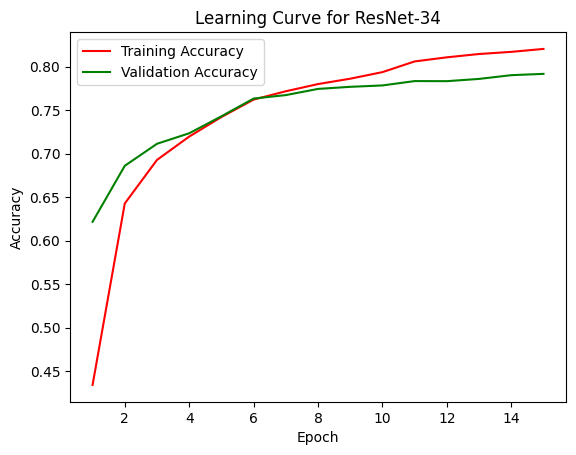

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.87      0.88      0.87      1000
           2       0.78      0.71      0.74      1000
           3       0.63      0.63      0.63      1000
           4       0.74      0.78      0.76      1000
           5       0.72      0.68      0.70      1000
           6       0.81      0.86      0.84      1000
           7       0.84      0.82      0.83      1000
           8       0.84      0.87      0.86      1000
           9       0.85      0.84      0.84      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



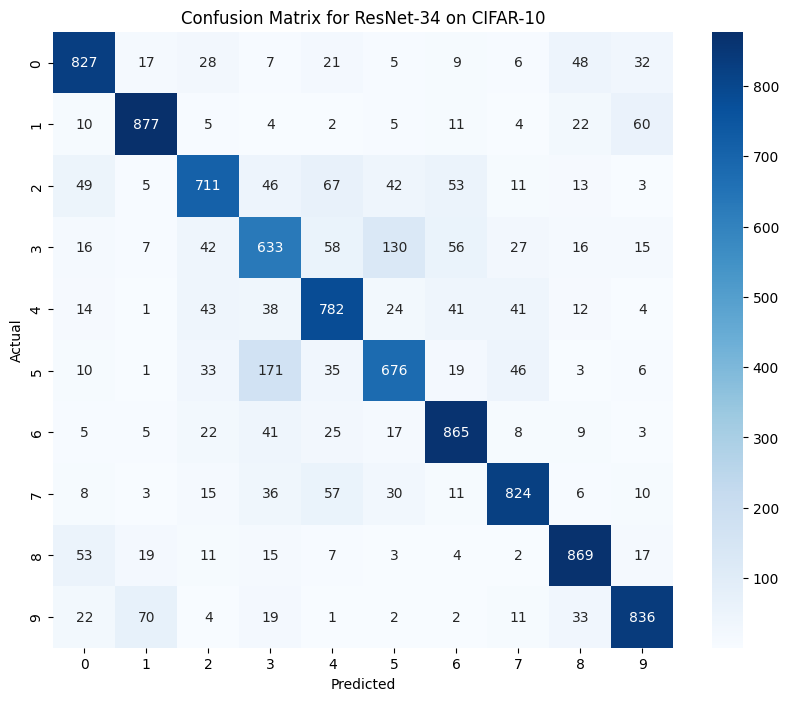

In [ ]:
# Load the modified ResNet-34 model with dropout in the final layer
class ResNet34_CIFAR10(nn.Module):
    def __init__(self):
        super(ResNet34_CIFAR10, self).__init__()
        # Load the ResNet-34 model pre-trained on ImageNet
        self.model = models.resnet34(pretrained=True)
        # Modify the final fully connected layer to output 10 classes for CIFAR-10 with dropout
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Adding dropout before the final layer
            nn.Linear(num_ftrs, 10)
        )

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34_CIFAR10().to(device)

# Training loop with early stopping
train_accuracies = []
val_accuracies = []
epochs = 15
early_stopping_patience = 3  # Stop if no improvement in validation accuracy for 'n' epochs
best_val_accuracy = 0
no_improvement_epochs = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for ResNet-34')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ResNet-34 on CIFAR-10')
plt.show()


**ResNet 34-Hyperparametric optimisation**

Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-07 08:49:54,583] A new study created in memory with name: no-name-74b0863e-d43d-4b30-9f76-587ea94090b7
[I 2024-11-07 08:54:17,629] Trial 0 finished with value: 0.673 and parameters: {'dropout_rate': 0.32147094249815267, 'learning_rate': 1.4908926860293658e-05, 'weight_decay': 9.811963870552195e-06}. Best is trial 0 with value: 0.673.
[I 2024-11-07 08:58:39,128] Trial 1 finished with value: 0.7832 and parameters: {'dropout_rate': 0.6142994644528781, 'learning_rate': 0.0002421292952248814, 'weight_decay': 5.722791497724078e-06}. Best is trial 1 with value: 0.7832.
[I 2024-11-07 09:03:00,912] Trial 2 finished with value: 0.7932 and parameters: {'dropout_rate': 0.35357551522333724, 'learning_rate': 0.00030835054909216295, 'weight_decay': 0.0002513262903006411}. Best is trial 2 with value: 0.7932.
[I 2024-11-07 09:07:22,542] Trial 3 finished with value: 0.7873 and parameters: {'dropout_rate': 0.48185565472678366, 'learning_rate': 0.00012841287766123766, 'weight_decay': 0.00027955

Best hyperparameters:  {'dropout_rate': 0.35357551522333724, 'learning_rate': 0.00030835054909216295, 'weight_decay': 0.0002513262903006411}
Epoch 1/15, Training Accuracy: 0.5499, Validation Accuracy: 0.6701
Epoch 2/15, Training Accuracy: 0.6848, Validation Accuracy: 0.6977
Epoch 3/15, Training Accuracy: 0.7216, Validation Accuracy: 0.7039
Epoch 4/15, Training Accuracy: 0.7389, Validation Accuracy: 0.7359
Epoch 5/15, Training Accuracy: 0.7564, Validation Accuracy: 0.7409
Epoch 6/15, Training Accuracy: 0.7877, Validation Accuracy: 0.7735
Epoch 7/15, Training Accuracy: 0.7961, Validation Accuracy: 0.7795
Epoch 8/15, Training Accuracy: 0.8040, Validation Accuracy: 0.7802
Epoch 9/15, Training Accuracy: 0.8089, Validation Accuracy: 0.7802
Epoch 10/15, Training Accuracy: 0.8145, Validation Accuracy: 0.7918
Epoch 11/15, Training Accuracy: 0.8331, Validation Accuracy: 0.8004
Epoch 12/15, Training Accuracy: 0.8363, Validation Accuracy: 0.8017
Epoch 13/15, Training Accuracy: 0.8437, Validation A

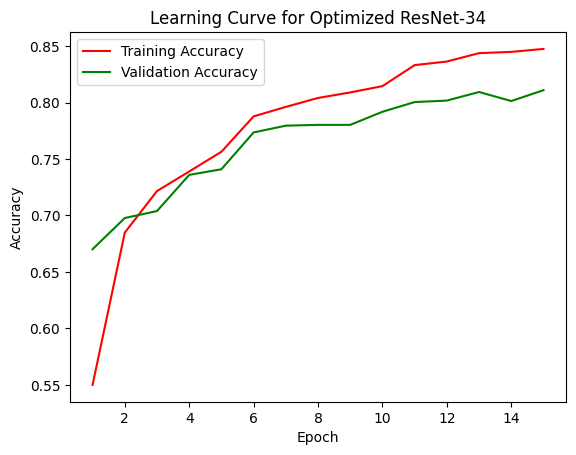

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.88      0.89      0.89      1000
           2       0.79      0.72      0.75      1000
           3       0.68      0.61      0.65      1000
           4       0.77      0.79      0.78      1000
           5       0.72      0.72      0.72      1000
           6       0.85      0.86      0.86      1000
           7       0.82      0.86      0.84      1000
           8       0.87      0.90      0.88      1000
           9       0.83      0.88      0.85      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



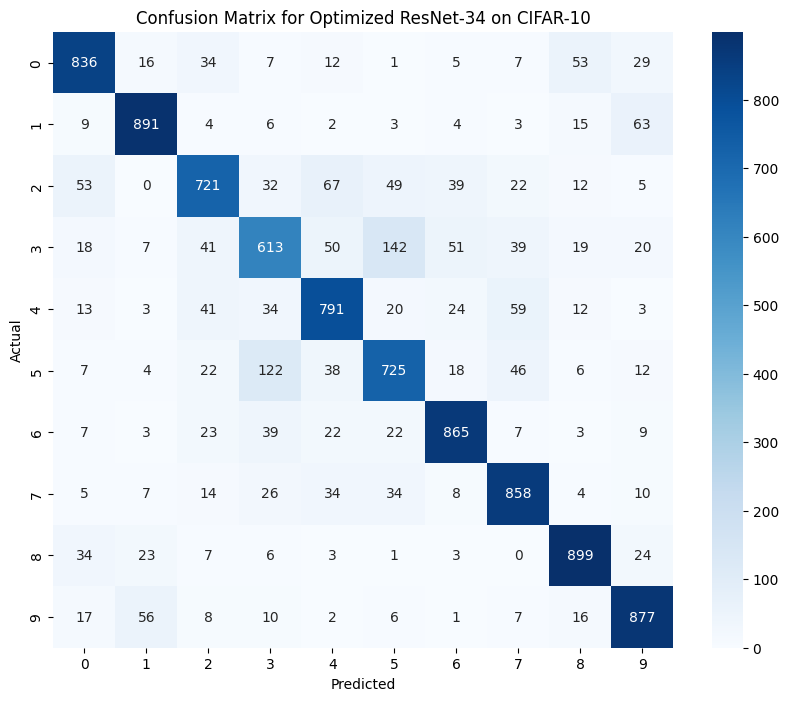

In [ ]:
# Define the ResNet-34 model with customizable dropout
class ResNet34_CIFAR10(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet34_CIFAR10, self).__init__()
        self.model = models.resnet34(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 10)
        )

    def forward(self, x):
        return self.model(x)

# Objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.7)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Model, criterion, optimizer, and scheduler
    model = ResNet34_CIFAR10(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training loop
    best_val_accuracy = 0
    early_stopping_patience = 3
    no_improvement_epochs = 0
    epochs = 10
    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        val_accuracy = correct_val / total_val
        scheduler.step()

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= early_stopping_patience:
                break

    return best_val_accuracy

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
model = ResNet34_CIFAR10(dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop for final model
train_accuracies = []
val_accuracies = []
epochs = 15

for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step()

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for Optimized ResNet-34')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized ResNet-34 on CIFAR-10')
plt.show()


**VGG-19---Baseline model**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Training Accuracy: 0.5542, Validation Accuracy: 0.6602
Epoch 2/15, Training Accuracy: 0.7110, Validation Accuracy: 0.7491
Epoch 3/15, Training Accuracy: 0.7527, Validation Accuracy: 0.7636
Epoch 4/15, Training Accuracy: 0.7791, Validation Accuracy: 0.7817
Epoch 5/15, Training Accuracy: 0.7967, Validation Accuracy: 0.7923
Epoch 6/15, Training Accuracy: 0.8248, Validation Accuracy: 0.8131
Epoch 7/15, Training Accuracy: 0.8333, Validation Accuracy: 0.8292
Epoch 8/15, Training Accuracy: 0.8430, Validation Accuracy: 0.8283
Epoch 9/15, Training Accuracy: 0.8457, Validation Accuracy: 0.8294
Epoch 10/15, Training Accuracy: 0.8529, Validation Accuracy: 0.8332
Epoch 11/15, Training Accuracy: 0.8663, Validation Accuracy: 0.8380
Epoch 12/15, Training Accuracy: 0.8698, Validation Accuracy: 0.8459
Epoch 13/15, Training Accuracy: 0.8729, Validation Accuracy: 0.8462
Epoch 14/15, Training Accuracy: 0.8769, Validatio

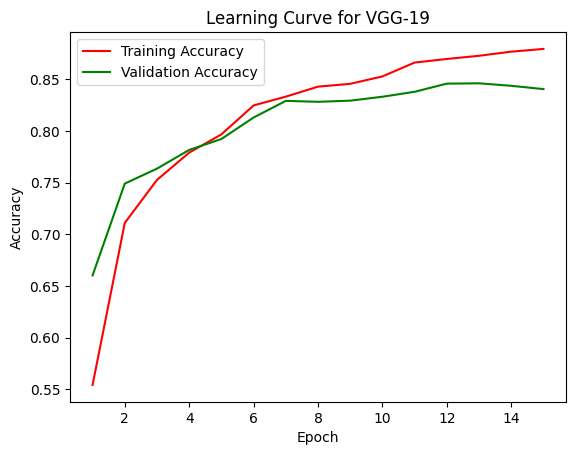

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1000
           1       0.91      0.97      0.94      1000
           2       0.90      0.84      0.87      1000
           3       0.79      0.74      0.76      1000
           4       0.83      0.90      0.86      1000
           5       0.83      0.81      0.82      1000
           6       0.93      0.92      0.92      1000
           7       0.90      0.91      0.91      1000
           8       0.92      0.95      0.94      1000
           9       0.91      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



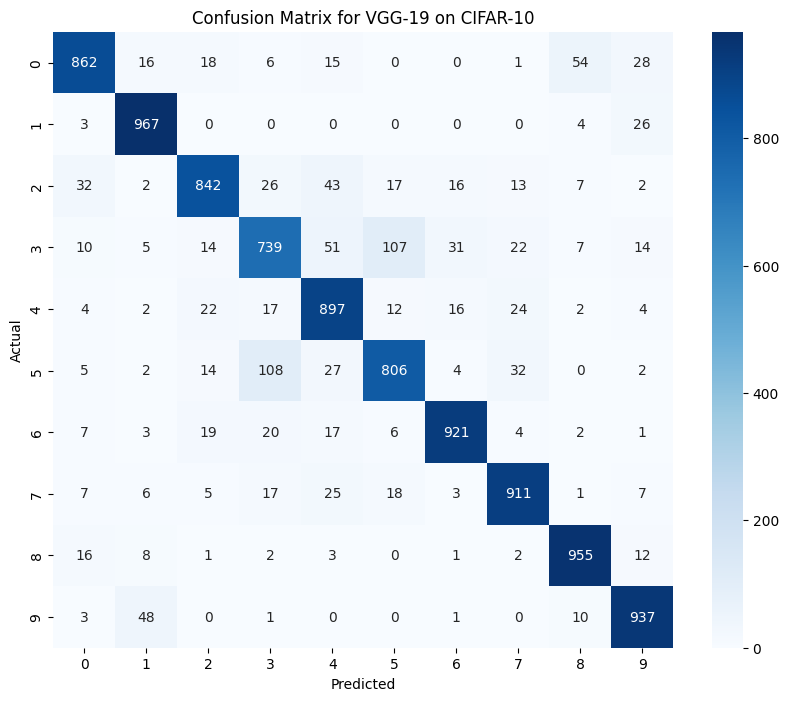

In [ ]:
# Define the VGG-19 model adapted for CIFAR-10 with increased dropout and batch normalization
class VGG19_CIFAR10(nn.Module):
    def __init__(self):
        super(VGG19_CIFAR10, self).__init__()
        # Load the VGG-19 model pre-trained on ImageNet
        self.model = models.vgg19(pretrained=True)
        # Modify the classifier to include dropout, batch normalization, and output 10 classes
        self.model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.6),  # Increased dropout
            nn.BatchNorm1d(4096),  # Batch normalization
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.6),  # Increased dropout
            nn.BatchNorm1d(4096),  # Batch normalization
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG19_CIFAR10().to(device)

# Data transformations with increased data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset and split it into training and validation sets
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Loss function and optimizer with reduced learning rate and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # Lowered learning rate

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with early stopping and gradient clipping
train_accuracies = []
val_accuracies = []
epochs = 15
early_stopping_patience = 3
best_val_accuracy = 0
no_improvement_epochs = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

# Plotting learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for VGG-19')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for VGG-19 on CIFAR-10')
plt.show()


**vgg-19---Hyperparametric optimisation**

Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-07 23:12:17,487] A new study created in memory with name: no-name-09a23448-6cd3-4dff-8531-7a3097b9966a
[I 2024-11-07 23:21:28,578] Trial 0 finished with value: 0.7738 and parameters: {'dropout_rate': 0.7, 'learning_rate': 1e-05, 'weight_decay': 1e-06}. Best is trial 0 with value: 0.7738.
[I 2024-11-07 23:30:39,448] Trial 1 finished with value: 0.7689 and parameters: {'dropout_rate': 0.7, 'learning_rate': 1e-05, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.7738.
[I 2024-11-07 23:39:50,454] Trial 2 finished with value: 0.7792 and parameters: {'dropout_rate': 0.5, 'learning_rate': 1e-05, 'weight_decay': 1e-06}. Best is trial 2 with value: 0.7792.
[I 2024-11-07 23:49:01,790] Trial 3 finished with value: 0.7835 and parameters: {'dropout_rate': 0.4, 'learning_rate': 1e-05, 'weight_decay': 0.001}. Best is trial 3 with value: 0.7835.
[I 2024-11-07 23:58:12,906] Trial 4 finished with value: 0.8327 and parameters: {'dropout_rate': 0.6, 'learning_rate': 5e-05, 'weight_decay':

Best trial:
  Accuracy: 0.8414
  Best hyperparameters:  {'dropout_rate': 0.4, 'learning_rate': 0.0001, 'weight_decay': 1e-05}
Epoch 1/15, Training Accuracy: 0.5858, Validation Accuracy: 0.6680
Epoch 2/15, Training Accuracy: 0.7231, Validation Accuracy: 0.7318
Epoch 3/15, Training Accuracy: 0.7643, Validation Accuracy: 0.7492
Epoch 4/15, Training Accuracy: 0.7877, Validation Accuracy: 0.7793
Epoch 5/15, Training Accuracy: 0.8036, Validation Accuracy: 0.7925
Epoch 6/15, Training Accuracy: 0.8385, Validation Accuracy: 0.8191
Epoch 7/15, Training Accuracy: 0.8492, Validation Accuracy: 0.8293
Epoch 8/15, Training Accuracy: 0.8549, Validation Accuracy: 0.8417
Epoch 9/15, Training Accuracy: 0.8631, Validation Accuracy: 0.8321
Epoch 10/15, Training Accuracy: 0.8696, Validation Accuracy: 0.8426
Epoch 11/15, Training Accuracy: 0.8841, Validation Accuracy: 0.8531
Epoch 12/15, Training Accuracy: 0.8896, Validation Accuracy: 0.8547
Epoch 13/15, Training Accuracy: 0.8942, Validation Accuracy: 0.8528

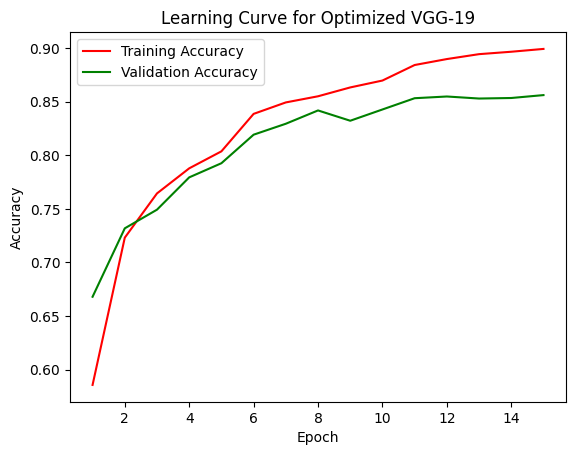

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1000
           1       0.95      0.96      0.96      1000
           2       0.87      0.90      0.88      1000
           3       0.79      0.80      0.80      1000
           4       0.86      0.89      0.87      1000
           5       0.87      0.80      0.83      1000
           6       0.94      0.93      0.93      1000
           7       0.92      0.92      0.92      1000
           8       0.92      0.96      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



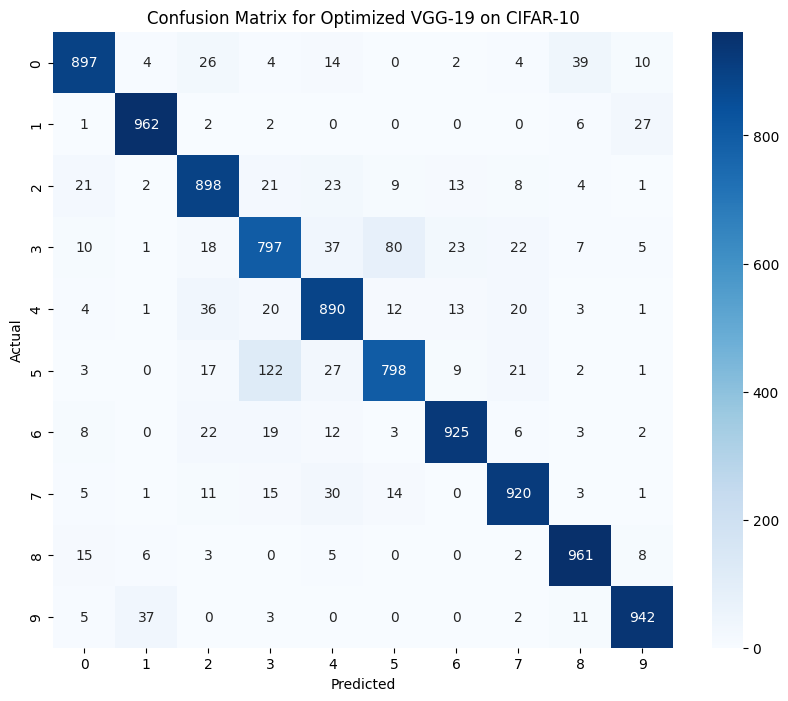

In [ ]:
# Define the VGG-19 model with customizable dropout rate
class VGG19_CIFAR10(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(VGG19_CIFAR10, self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        return self.model(x)


# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune with baseline values included
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.5, 0.4, 0.6, 0.7])
    learning_rate = trial.suggest_categorical("learning_rate", [0.00005, 1e-5, 5e-5, 1e-4, 1e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-4, 1e-6, 1e-5, 1e-3])

    # Initialize model, loss, and optimizer with suggested hyperparameters
    model = VGG19_CIFAR10(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training with early stopping
    best_val_accuracy = 0
    no_improvement_epochs = 0
    early_stopping_patience = 3
    epochs = 10  # Fewer epochs for quicker tuning

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        val_accuracy = correct_val / total_val
        scheduler.step()

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= early_stopping_patience:
                break

    return best_val_accuracy

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best trial:")
print(f"  Accuracy: {study.best_trial.value}")
print("  Best hyperparameters: ", study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params
model = VGG19_CIFAR10(dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop for final model
train_accuracies = []
val_accuracies = []
epochs = 15

for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    scheduler.step()

# Plot learning curves
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for Optimized VGG-19')
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized VGG-19 on CIFAR-10')
plt.show()
